Note:
* same seq = same block cluster **[start from similarity of sequences first]**
* 1. use all sequences that were generated to measure the similarity
* 2. use only sequences that are predictive to measure the similarity


* workflow:
 1. targetencoded all columns. Use it when selecting best kmeans
 2. create similarity measurement. Checked and found that some labels are close to uniquely represent a block cluster
 3. Train the predicting model using target encoded cols + one hot encoded similarity measurement >> see improvement

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from interpolation import CensusData, sequences, BlockInterpolator, CentroidInterpolator, archive, interpolation
from sklearn.pipeline import Pipeline
from category_encoders.target_encoder import TargetEncoder
from xgboost import XGBClassifier
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

from kmodes.kmodes import KModes
from sklearn.compose import ColumnTransformer


In [4]:
#Change these values to rerun the notebook
filled_1850 = pd.read_csv("../../data/dwelling_filled_sum_1850_mn_v01.csv")
cd_1850 = pd.read_csv("../../data/cd_1850_XYupdate.csv") #For calculating centroids
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"Ward_Num", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num", "CENSUS_REEL_HOUSEHOLD":"CENSUS_REEL", "CENSUS_SEX":"CENSUS_SEXB", "CENSUS_PAGENO_HOUSEHOLD":"CENSUS_PAGENUM", "CENSUS_RACE":"CENSUS_RACEB", "CD_X":"cd_X", "CD_Y":"cd_Y"}, inplace = True)
ward_col = "Ward_Num"
dwelling_col = "dwelling_id"
dwelling_col_num = "CENSUS_DWELLING_NUM"
block_col = "block_num"
x_col = "cd_X"
y_col = "cd_Y"
pagenum = "CENSUS_PAGENNO"

In [117]:
print(filled_1850.shape)
print(filled_1850.loc[~filled_1850['block_num'].isnull()].shape)
print(filled_1850.loc[filled_1850['block_num'].isnull()].shape)

(515630, 32)
(166500, 32)
(349130, 32)


In [10]:
#set clustering algo -- this is to make sure that the same clustering algorithm is used
#for each model, to ensure that testing is accurate
#note fitting before hand won't work for all types of clustering, for example, with agglomerative
#clustering this isn't going to work because the algorithm doesn't have a predict method
block_centroids = {ward:{block:interpolation.make_centroid(df_block[x_col], df_block[y_col]) for block, df_block in df.groupby(block_col)} for ward,df in cd_1850.groupby(ward_col)}

## Incooperate Enumerator sequence

In [3]:
enumerators = pd.read_csv("../../data/census_1850_enumerationDetail_mn_ward10.csv")

In [5]:
ward10 = filled_1850[filled_1850[ward_col] == 10]
ward10_enumerators = ward10.merge(enumerators,  how = "left", left_on= "CENSUS_PAGENUM", right_on = "CENSUS_PAGENO_HOUSEHOLD")

In [35]:
census_enum_seq = CensusData(ward10_enumerators, ward_col=ward_col, dwelling_col=dwelling_col, 
                             block_col =  block_col, x_col = x_col, y_col = y_col, pagenum = pagenum)
census_enum_seq.apply_sequencing(enumerator_dist = True, dwelling = True, fixed = True, distance = True)

In [36]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                     n_estimators = 50))])

n is 5 and it's the 0th iteration
n is 5 and it's the 50th iteration


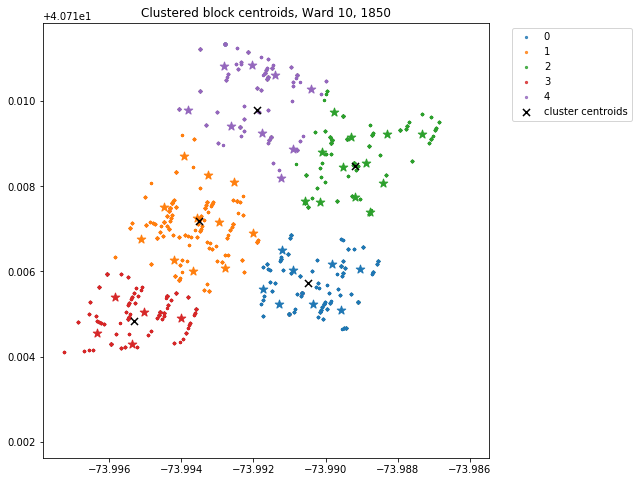

In [37]:
interpolate_sequences = CentroidInterpolator(census_enum_seq, 10, block_boost, all_cols, KMeans(5), block_centroids)
score, model = interpolate_sequences.kmeans_best(5)
interpolate_sequences.set_clustering_algo(model)
interpolate_sequences.apply_clustering(algo_fit = True)
interpolate_sequences.clustervis(kmeans = True)

In [38]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 1.0
Test score: [0.6164510166358595, 0.5125506072874494, 0.5206463195691203, 0.5305039787798409, 0.5872756933115824, 0.4738988580750408, 0.6540084388185654, 0.45723684210526316, 0.5664893617021277, 0.4991961414790997]
avg Test score: 0.541825725776395


### Create similarity measurement [only sequences]

In [39]:
similar_cols = ["sequence_id", "dwelling_seq_id", "fixed_seq", "enum_dist_id"]
print(len(similar_cols))

4


In [40]:
## take only columns to be clustered
## unknown values are treated as a new category
similarity_df = interpolate_sequences.df[similar_cols].copy()
similarity_df.fillna(value=-1, inplace=True)

In [41]:
## process data fro Kmodes. Convert all columns into string
for c in similarity_df.columns:
    similarity_df[c] = similarity_df[c].astype('str')

#### run k modes

In [42]:
K = 20

km_cao = KModes(n_clusters=K, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(similarity_df, categorical=[i for i in range(1,len(similar_cols))])

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 11174.0


#### see how block clusters are distributioned in each similarity cluster

In [43]:
k_modes_result = interpolate_sequences.df.copy()
k_modes_result['kmodes'] = fitClusters_cao

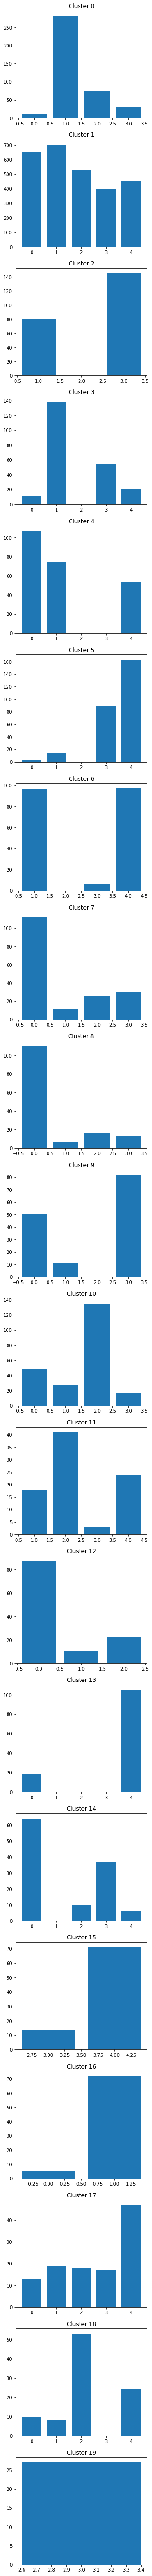

In [44]:
fig, ax = plt.subplots(K,1, figsize = (5, 100))
for k in range(K):
    temp = k_modes_result[['block_num', 'cluster', 'kmodes']]
    temp = temp.loc[temp['kmodes'] == k]['cluster'].value_counts()
    temp.sort_index(inplace=True)
    ax[k].bar(temp.index, temp.values)
    ax[k].set_title('Cluster ' +str(k))
    

There are some similarity clusters that represent some block cluster well.
* 6 >> 0 or 3
* 8 >> 4
* 12 >> 4
* 13 >> 0
* 15 >> 0
* 16 >> 3
* 18 >> 2
* 19 >> 1

#### train a predicting model that uses the similarity measure as a categorical varaible. **Not target encoded

In [45]:
all_cols = ["CENSUS_SERIALB", "CENSUS_AGE", "CENSUS_PAGENUM", "CENSUS_SEXB", "CENSUS_RACEB", 
            "sequence_id", "CENSUS_DWELLING_SIZE","CENSUS_SEQ_NUM", "CENSUS_LABFORCE", "CENSUS_LINE", 
            "CENSUS_MARST", "CENSUS_NAMEFRST", "CENSUS_NAMELAST", "CENSUS_OCCSTR", "CENSUS_IMPREL",
            "sequence_order_enum", 'CENSUS_DWELLING_SEQ', "dwelling_seq_id", "fixed_seq", "enum_dist_id", 
            "enum_dist_order"]
block_boost = Pipeline([('preprocess', TargetEncoder(cols = all_cols)),
                        ('classifier', XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                     n_estimators = 50))])

In [46]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [47]:
transformer = ColumnTransformer(transformers=[('target', TargetEncoder(), all_cols), 
                                              ('onehot', OneHotEncoder(handle_unknown='ignore'), ['kmodes'])])
# define pipeline
pipeline = Pipeline(steps=[('preprocess', transformer), 
                           ('classifier',XGBClassifier(colsample_bytree = 0.6, max_depth = 2, 
                                                       n_estimators = 50))])

In [48]:
## Change some global info 

interpolate_sequences.df = k_modes_result
interpolate_sequences.feature_names = all_cols + ['kmodes']
interpolate_sequences.model = pipeline

In [49]:
interpolate_sequences.model

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('target', TargetEncoder(),
                                                  ['CENSUS_SERIALB',
                                                   'CENSUS_AGE',
                                                   'CENSUS_PAGENUM',
                                                   'CENSUS_SEXB',
                                                   'CENSUS_RACEB',
                                                   'sequence_id',
                                                   'CENSUS_DWELLING_SIZE',
                                                   'CENSUS_SEQ_NUM',
                                                   'CENSUS_LABFORCE',
                                                   'CENSUS_LINE',
                                                   'CENSUS_MARST',
                                                   'CENSUS_NAMEFRST',
                                                   'CENSUS_NAMELAST',
   

In [50]:
## retrain model using kmodes result

interpolate_sequences.cross_validate_model(k=10)
print('Cross Validation')
print("avg Training score:", np.array(interpolate_sequences.train_score).mean())
print('Test score:', interpolate_sequences.test_score)
print("avg Test score:", np.array(interpolate_sequences.test_score).mean())

Cross Validation
avg Training score: 0.97785316874443
Test score: [0.6377079482439926, 0.5497975708502024, 0.5, 0.5579133510167993, 0.5554649265905384, 0.6615008156606852, 0.6413502109704642, 0.5838815789473685, 0.5939716312056738, 0.5482315112540193]
avg Test score: 0.5829819544739745


### The cross validation score improves from 0.54 (see above) to 0.59 when the similarity score is included

In [102]:
interpolate_sequences.feature_names

['sequence_order_enum',
 'CENSUS_PAGENUM',
 'sequence_id',
 'CENSUS_DWELLING_SIZE',
 'CENSUS_SEQ_NUM',
 'CENSUS_LABFORCE',
 'CENSUS_LINE',
 'CENSUS_NAMELAST',
 'CENSUS_IMPREL',
 'CENSUS_ID',
 'CENSUS_DWELLING_SEQ',
 'fixed_seq',
 'kmodes']